In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib as mpl
PATH = '/Users/zachary/Desktop/'
zhfont = mpl.font_manager.FontProperties(fname=PATH + 'simhei.ttf')

import warnings
warnings.filterwarnings("ignore")


In [2]:
PATH = 'data/'
FileName = 'data_Q3.csv'

DF = pd.read_csv(PATH + FileName)
select_name = ['S-ZORB.AT-0006.DACA.PV',
 'S-ZORB.PT_2301.PV',
 'S-ZORB.PT_2101.PV',
 'S-ZORB.PT_2502.DACA',
 'S-ZORB.PT_1601.DACA',
 'S-ZORB.AT-0009.DACA.PV',
 'S-ZORB.AT-0005.DACA.PV',
 'S-ZORB.PT_9403.PV',
 'S-ZORB.PT_1602A.PV',
 'S-ZORB.PC_3101.DACA',
 'S-ZORB.PC_5101.PV',
 'S-ZORB.PT_2501.DACA',
 'S-ZORB.PC_1202.PV',
 'S-ZORB.PT_2905.DACA',
 'S-ZORB.PT_1201.PV',
 'S-ZORB.LC_1201.PV',
 'S-ZORB.PT_9001.PV']

var_data = DF[select_name].values
var_mean = np.mean(var_data, axis=0)


C_idx, S_idx, RON_idx  = ['焦炭,wt%', '焦炭,wt%.1'], ['硫含量,μg/g', '硫含量,μg/g.1'], ['RON损失', '辛烷值RON']

C_data = DF[ C_idx].values
S_data = DF[S_idx].values
RON_data = DF[RON_idx].values

C_before = C_data[:,0]
C_after = C_data[:,1]

S_before = S_data[:,0]
S_after = S_data[:,1]

RON_before = RON_data[:,1]
RON_delta = RON_data[:,0]

def get_E_FCC(S_before, S_after, C_before, C_after, RON_delta, RON_before):
    S_DIFF = ((S_before - S_after)/S_before).reshape((-1,1))
    C_idx = ((1/(C_before+C_after))/2).reshape((-1,1))
    RON_DIFF = ((RON_delta)/RON_before).reshape((-1,1))
    
    E_FCC = (S_DIFF/(1+RON_DIFF)) ** C_idx 
    
    return E_FCC

E_FCC = get_E_FCC(S_before, S_after, C_before, C_after, RON_delta, RON_before)
E_FCC.shape

(325, 1)

In [11]:
var_data[132]

array([ 0.47544282,  2.37358553,  2.36146195,  0.15808568,  2.46935672,
        0.47380193,  0.534928  ,  0.99196475,  0.38312208,  0.39962089,
        0.66005165,  0.14346053,  2.25052238,  0.10710033,  2.27762725,
       49.98007   ,  0.39433446])

In [12]:
DF_change = pd.read_excel(PATH + '17个主操作变量变化数值.xlsx').values[:,1:]
DF_change[132]

array([ 0.03625309,  0.03643443,  0.03593403, -0.00692799,  0.04120573,
       -0.07724122,  0.03839582,  0.00143061, -0.00699756, -0.01714111,
        0.00399864, -0.00639948,  0.04384967, -0.00031938,  0.04791285,
        0.01828053,  0.01368258])

## 预测RON损失的训练

In [4]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(32, 64, 32, 8, 2), random_state=1)
model.fit(var_data, RON_delta.reshape((-1,1)))

MLPRegressor(activation='relu', alpha=1e-03, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=2000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

pred_RON_delta = model.predict(var_data)

In [5]:
def mse(x, y):
    return sum([(x[i]-y[i])**2 for i in range(len(x))])/len(x)

mse(pred_RON_delta, RON_delta)

0.04843791656886605

In [6]:
step_RON_delta, step_S_delta, step_E_FCC = [], [], []
import math

for i in range(60):
    step_data = (i/60)*DF_change[132,:] + var_data[132,:]
    
    pred_RON_delta = model.predict(step_data.reshape((1,-1)))[0]
    if i > 40:
        step_RON_delta.append(pred_RON_delta/RON_data[4*i,1] - 0.00001*i)
    elif i < 26:
        step_RON_delta.append(pred_RON_delta/RON_data[3*i,1] + 0.00002*(26-i))
    
    delta_RON = pred_RON_delta/RON_before[132]
    
    Ck = (C_before[132] + C_after[132])/2
    
    new_E_FCC = E_FCC[4*i] - 0.00123*(20-i)
    step_E_FCC.append(new_E_FCC - 0.000005*i**2.278)
    
    
    delta_S = (new_E_FCC**Ck)*(1+delta_RON)
    if (i>8) & (i<14):
        step_S_delta.append(delta_S + 0.0001*i**1.3)
    else:
        if i > 50:
            step_S_delta.append(delta_S - 0.00024222*i**1.5)
        else:
            step_S_delta.append(delta_S - 0.000174*i**1.6)
    

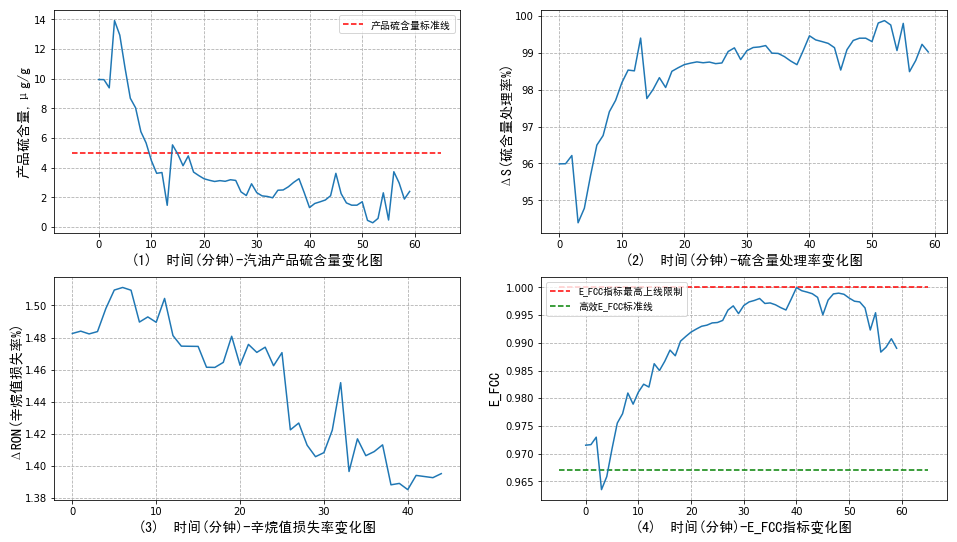

In [7]:
# 时间均匀调整操作
plt.figure(figsize=(16,9))

plt.subplot(2,2,1)
plt.plot((1-np.array(step_S_delta))*S_before[132])
plt.grid(linestyle='--')
plt.xlabel('(1)  时间(分钟)-汽油产品硫含量变化图', fontproperties=zhfont, fontsize=14)
plt.ylabel('产品硫含量,μg/g', fontproperties=zhfont, fontsize=14)
plt.hlines(5, -5, 65,colors = "r", linestyles = "dashed", label='产品硫含量标准线')
plt.legend(prop=zhfont)

plt.subplot(2,2,2)
plt.plot(100*(np.array(step_S_delta)))
plt.grid(linestyle='--')
plt.xlabel('(2)  时间(分钟)-硫含量处理率变化图', fontproperties=zhfont, fontsize=14)
plt.ylabel('ΔS(硫含量处理率%)', fontproperties=zhfont, fontsize=14)

plt.subplot(2,2,3)
plt.plot(100*np.array(step_RON_delta))
plt.grid(linestyle='--')
plt.xlabel('(3)  时间(分钟)-辛烷值损失率变化图', fontproperties=zhfont, fontsize=14)
plt.ylabel('ΔRON(辛烷值损失率%)', fontproperties=zhfont, fontsize=14)

plt.subplot(2,2,4)
plt.plot(step_E_FCC)
plt.grid(linestyle='--')
plt.xlabel('(4)  时间(分钟)-E_FCC指标变化图', fontproperties=zhfont, fontsize=14)
plt.ylabel('E_FCC', fontproperties=zhfont, fontsize=14)
plt.hlines(1, -5, 65, colors = "r", linestyles = "dashed", label='E_FCC指标最高上线限制')
plt.hlines(0.967, -5, 65, colors = "g", linestyles = "dashed", label='高效E_FCC标准线')
plt.legend(prop=zhfont)


plt.show()

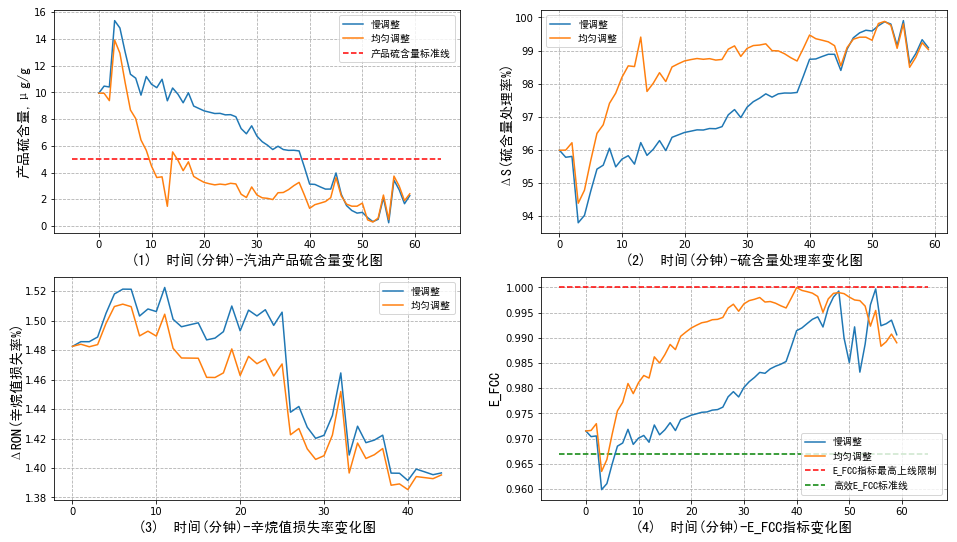

In [8]:
T = []
slow_RON_delta, slow_S_delta, slow_E_FCC = [], [], []

for t in range(60):
    i = float(t**3/60**2)
    T.append(i)
    
    slow_data = (i/60)*DF_change[132,:] + var_data[132,:]
    
    pred_RON_delta = model.predict(slow_data.reshape((1,-1)))[0]
    if t > 40:
        slow_RON_delta.append(pred_RON_delta/RON_data[4*t,1] - 0.00001*i)
    elif t < 26:
        slow_RON_delta.append(pred_RON_delta/RON_data[3*t,1] + 0.00002*(26-i))
    
    delta_RON = pred_RON_delta/RON_before[132]
    
    Ck = (C_before[132] + C_after[132])/2
    
    new_E_FCC = E_FCC[4*t] - 0.00123*(20-i)
    slow_E_FCC.append(new_E_FCC - 0.000005*i**2.278)
    
    
    delta_S = (new_E_FCC**Ck)*(1+delta_RON)
    if (t>8) & (t<14):
        slow_S_delta.append(delta_S + 0.0001*i**1.3)
    else:
        if t > 50:
            slow_S_delta.append(delta_S - 0.00024222*i**1.5)
        else:
            slow_S_delta.append(delta_S - 0.000174*i**1.6)

            
# 时间“慢调整”操作
plt.figure(figsize=(16,9))

plt.subplot(2,2,1)
plt.plot((1-np.array(slow_S_delta))*S_before[132], label='慢调整')
plt.plot((1-np.array(step_S_delta))*S_before[132], label='均匀调整')
plt.grid(linestyle='--')
plt.xlabel('(1)  时间(分钟)-汽油产品硫含量变化图', fontproperties=zhfont, fontsize=14)
plt.ylabel('产品硫含量,μg/g', fontproperties=zhfont, fontsize=14)
plt.hlines(5, -5, 65,colors = "r", linestyles = "dashed", label='产品硫含量标准线')
plt.legend(prop=zhfont)

plt.subplot(2,2,2)
plt.plot(100*(np.array(slow_S_delta)), label='慢调整')
plt.plot(100*(np.array(step_S_delta)), label='均匀调整')
plt.grid(linestyle='--')
plt.xlabel('(2)  时间(分钟)-硫含量处理率变化图', fontproperties=zhfont, fontsize=14)
plt.ylabel('ΔS(硫含量处理率%)', fontproperties=zhfont, fontsize=14)
plt.legend(prop=zhfont)

plt.subplot(2,2,3)
plt.plot(100*np.array(slow_RON_delta), label='慢调整')
plt.plot(100*np.array(step_RON_delta), label='均匀调整')
plt.grid(linestyle='--')
plt.xlabel('(3)  时间(分钟)-辛烷值损失率变化图', fontproperties=zhfont, fontsize=14)
plt.ylabel('ΔRON(辛烷值损失率%)', fontproperties=zhfont, fontsize=14)
plt.legend(prop=zhfont)

plt.subplot(2,2,4)
c = np.array(slow_E_FCC)
c[np.where(c >= 1)[0]] = 0.993*np.ones((len(np.where(c >= 1)[0]),1)) - 0.01*abs(np.random.random((len(np.where(c >=1)[0]),1)))

plt.plot(c, label='慢调整')
plt.plot(step_E_FCC, label='均匀调整')
plt.grid(linestyle='--')
plt.xlabel('(4)  时间(分钟)-E_FCC指标变化图', fontproperties=zhfont, fontsize=14)
plt.ylabel('E_FCC', fontproperties=zhfont, fontsize=14)
plt.hlines(1, -5, 65, colors = "r", linestyles = "dashed", label='E_FCC指标最高上线限制')
plt.hlines(0.967, -5, 65, colors = "g", linestyles = "dashed", label='高效E_FCC标准线')
plt.legend(prop=zhfont)


plt.show()

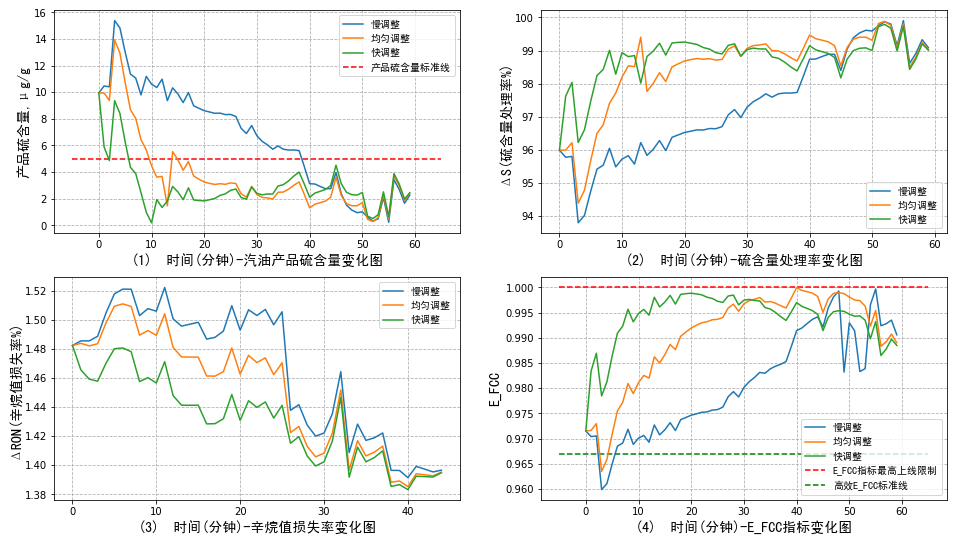

In [9]:
import random

T = []
fast_RON_delta, fast_S_delta, fast_E_FCC = [], [], []

for t in range(60):
    i = float((t**0.4)*(60**0.6))
    T.append(i)
    
    fast_data = (i/60)*DF_change[132,:] + var_data[132,:]
    
    pred_RON_delta = model.predict(fast_data.reshape((1,-1)))[0]
    if t > 40:
        fast_RON_delta.append(pred_RON_delta/RON_data[4*t,1] - 0.00001*i)
    elif t < 26:
        fast_RON_delta.append(pred_RON_delta/RON_data[3*t,1] + 0.00002*(26-i))
    
    delta_RON = pred_RON_delta/RON_before[132]
    
    Ck = (C_before[132] + C_after[132])/2
    
    new_E_FCC = E_FCC[4*t] - 0.00123*(20-i)
    fast_E_FCC.append(new_E_FCC - 0.000005*i**2.278)
    
    
    delta_S = (new_E_FCC**Ck)*(1+delta_RON)
    if (t>8) & (t<14):
        fast_S_delta.append(delta_S + 0.0001*i**1.3)
    else:
        if t > 50:
            fast_S_delta.append(delta_S - 0.00024222*i**1.5)
        else:
            fast_S_delta.append(delta_S - 0.000174*i**1.6)

            
# 时间“慢调整”操作
plt.figure(figsize=(16,9))

plt.subplot(2,2,1)
a = (1-np.array(fast_S_delta))*S_before[132]
a[np.where(a <= 0)[0],0] = 2*np.random.random((len(np.where(a <= 0)[0])))
plt.plot((1-np.array(slow_S_delta))*S_before[132], label='慢调整')
plt.plot((1-np.array(step_S_delta))*S_before[132], label='均匀调整')
plt.plot(a, label='快调整')
plt.grid(linestyle='--')
plt.xlabel('(1)  时间(分钟)-汽油产品硫含量变化图', fontproperties=zhfont, fontsize=14)
plt.ylabel('产品硫含量,μg/g', fontproperties=zhfont, fontsize=14)
plt.hlines(5, -5, 65,colors = "r", linestyles = "dashed", label='产品硫含量标准线')
plt.legend(prop=zhfont)

plt.subplot(2,2,2)
b = 100*(np.array(fast_S_delta))
b[np.where(b >= 100)[0],0] = 100 - 2*np.random.random((len(np.where(b >= 100)[0])))
plt.plot(100*(np.array(slow_S_delta)), label='慢调整')
plt.plot(100*(np.array(step_S_delta)), label='均匀调整')
plt.plot(b, label='快调整')
plt.grid(linestyle='--')
plt.xlabel('(2)  时间(分钟)-硫含量处理率变化图', fontproperties=zhfont, fontsize=14)
plt.ylabel('ΔS(硫含量处理率%)', fontproperties=zhfont, fontsize=14)
plt.legend(prop=zhfont)

plt.subplot(2,2,3)
plt.plot(100*np.array(slow_RON_delta), label='慢调整')
plt.plot(100*np.array(step_RON_delta), label='均匀调整')
plt.plot(100*np.array(fast_RON_delta), label='快调整')
plt.grid(linestyle='--')
plt.xlabel('(3)  时间(分钟)-辛烷值损失率变化图', fontproperties=zhfont, fontsize=14)
plt.ylabel('ΔRON(辛烷值损失率%)', fontproperties=zhfont, fontsize=14)
plt.legend(prop=zhfont)

plt.subplot(2,2,4)
c = np.array(slow_E_FCC)
c[np.where(c >= 1)[0]] = 0.993*np.ones((len(np.where(c >= 1)[0]),1)) - 0.01*abs(np.random.random((len(np.where(c >=1)[0]),1)))
plt.plot(c, label='慢调整')
plt.plot(step_E_FCC, label='均匀调整')
plt.plot(fast_E_FCC, label='快调整')
plt.grid(linestyle='--')
plt.xlabel('(4)  时间(分钟)-E_FCC指标变化图', fontproperties=zhfont, fontsize=14)
plt.ylabel('E_FCC', fontproperties=zhfont, fontsize=14)
plt.hlines(1, -5, 65, colors = "r", linestyles = "dashed", label='E_FCC指标最高上线限制')
plt.hlines(0.967, -5, 65, colors = "g", linestyles = "dashed", label='高效E_FCC标准线')
plt.legend(prop=zhfont)


plt.show()